SHAP ANALYSIS

In [2]:
import os
import hopsworks
import joblib
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path



In [3]:
# 1. LOGIN INTO HOPSWORKS

os.environ["HOPSWORKS_API_KEY"] = "DGdCrO6zZkBc42ad.L1OpxZ0oXVXn9Md1YPllyCIu8XOj0Q3epPmrVZeoJikQ9mNdJTe9uqtsZAQQ93FJ"

print("🔌 Connecting to Hopsworks...")
project = hopsworks.login()
fs = project.get_feature_store()

# 2. DOWNLOAD LATEST MODEL FROM MODEL  REGISTRY

print("📥 Fetching LATEST Model from Registry...")
mr = project.get_model_registry()


models = mr.get_models("karachi_aqi_best_model")

if not models:
    print("❌ No models found in registry!")
else:
    #pickup the latest version
    model_meta = max(models, key=lambda x: x.version)
    print(f"✅ Found Latest Model: {model_meta.name} (v{model_meta.version})")

    # Download the files
    download_path = model_meta.download()
    download_dir = Path(download_path)

    # Smart Loader: Find the files wherever they are
    try:
        # Search for scaler.pkl
        scaler_files = list(download_dir.rglob("scaler.pkl"))
        if not scaler_files:
            raise FileNotFoundError("scaler.pkl not found in this version.")
        scaler_file = scaler_files[0]
        
        # Search for model file (any .pkl that is NOT scaler.pkl)
        model_files = [f for f in download_dir.rglob("*.pkl") if "scaler.pkl" not in f.name]
        if not model_files:
             raise FileNotFoundError("model .pkl file not found in this version.")
        model_file = model_files[0]
        
        print(f"Loading Scaler: {scaler_file.name}")
        print(f"Loading Model:  {model_file.name}")
        
        scaler = joblib.load(scaler_file)
        model = joblib.load(model_file)
        print("✅ Model loaded successfully!")
        
    except Exception as e:
        print(f"❌ Error loading files from v{model_meta.version}: {e}")
        print("💡 Tip: Ensure your 'train_model.py' ran successfully and uploaded both files.")



🔌 Connecting to Hopsworks...
2026-02-09 23:09:52,354 INFO: Initializing external client
2026-02-09 23:09:52,356 INFO: Base URL: https://c.app.hopsworks.ai:443


2026-02-09 23:10:04,233 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1338528
📥 Fetching LATEST Model from Registry...
✅ Found Latest Model: karachi_aqi_best_model (v30)


Downloading: 0.000%|          | 0/1951 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/495633 elapsed<00:00 remaining<?

Loading Scaler: scaler.pkl (0 dirs, 2 files)... DONE
Loading Model:  best_model.pkl
✅ Model loaded successfully!


In [4]:
# 3. FETCH & PREPARE DATA (From feature group)

print("📊 Fetching Test Data from Feature Group...")

# 1. Get the Feature Group
fg = fs.get_feature_group(name="karachi_aqi_features", version=7)

# 2. Read the dataframe
df = fg.read()

# 3. Sort by Date! 

if 'datetime' in df.columns:
    df = df.sort_values('datetime').reset_index(drop=True)

# 4. Clean the data (Drop targets and non-feature columns)
# Drop 'aqi' because that is the Answer (y), not a Question (X)
drop_cols = ["aqi", "datetime", "aqi_change", "aqi_pct_change", "target_aqi_24h"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# 5. Take the Test Set (last 20%)
split_idx = int(len(X) * 0.8)
X_test = X.iloc[split_idx:]

# 6. Handle NaNs
X_test = X_test.fillna(0)

print(f"✅ Data Loaded. Testing on {len(X_test)} rows.")
print("   Columns:", list(X_test.columns))

📊 Fetching Test Data from Feature Group...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (57.62s) 
✅ Data Loaded. Testing on 923 rows.
   Columns: ['pm2_5', 'pm10', 'nitrogen_dioxide', 'ozone', 'sulphor_dioxide', 'carbon_monooxide', 'temp_c', 'humidity', 'wind_speed_kph', 'precipitation_mm', 'year', 'month', 'day', 'hour', 'day_of_week', 'temp_humid_interaction', 'wind_pollution_interaction', 'aqi_lag_1', 'aqi_roll_max_24h']


🧪 Ready for analysis on 200 samples.
🚀 Calculating SHAP values...
✅ TreeExplainer used successfully.


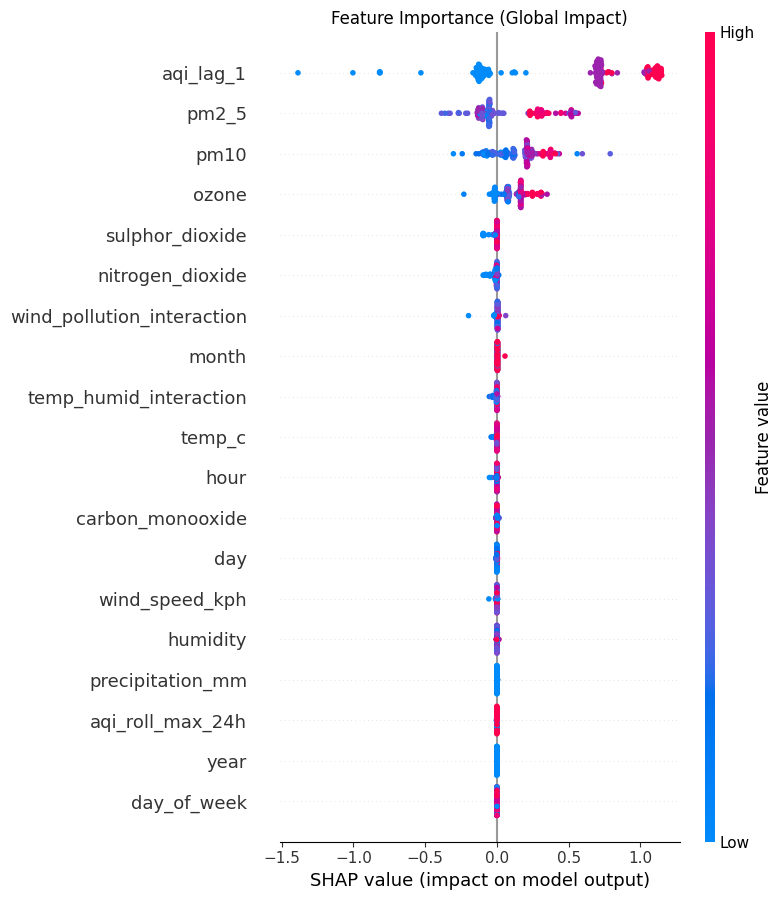

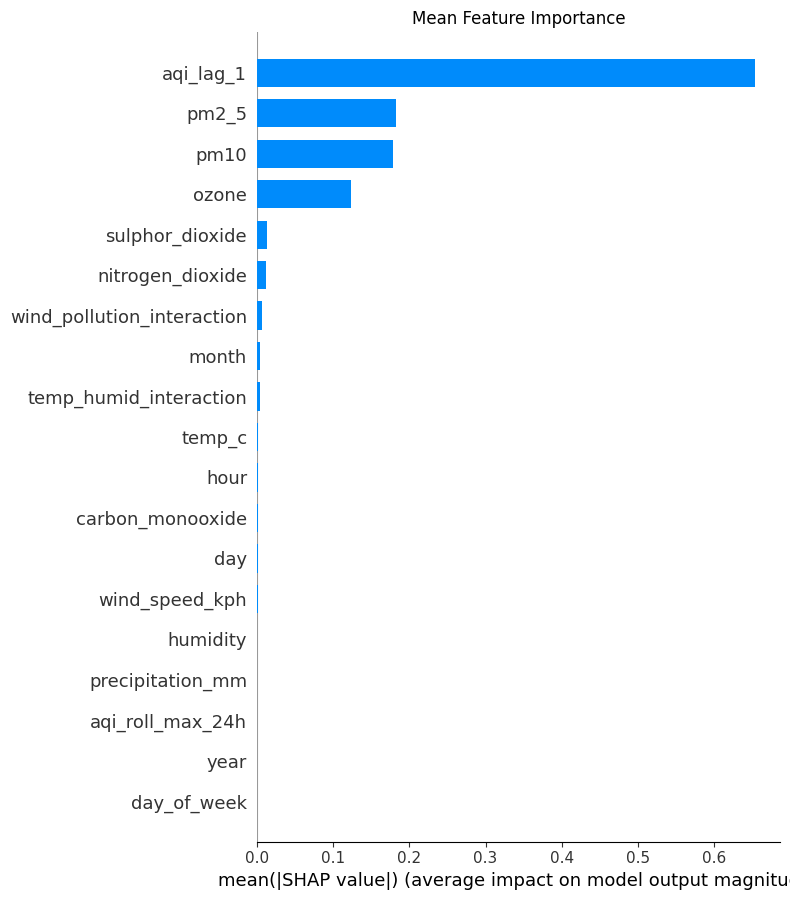

In [6]:
# 4. SCALE THE DATA

# Does scale X_test before passing it to SHAP.
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame so SHAP plots show column names
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Taking the most recent 200 data points is usually enough
X_sample = X_test_df.tail(200)

print(f"🧪 Ready for analysis on {len(X_sample)} samples.")

# 5. RUN SHAP ANALYSIS

print("🚀 Calculating SHAP values...")

try:
    # A. For Tree Models (XGBoost, RandomForest, LightGBM) - FAST
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)
    
    print("✅ TreeExplainer used successfully.")
    
except Exception as e:
    # B. For Other Models (Linear, LSTM, etc.) - SLOWER
    print(f"⚠️ TreeExplainer failed ({e}). Trying KernelExplainer (this might take a minute)...")
    
    # KernelExplainer needs a summary of the background dataset 
    background = shap.kmeans(X_test_df, 50) 
    explainer = shap.KernelExplainer(model.predict, background)
    shap_values = explainer.shap_values(X_sample)


# 6. VISUALIZATIONS
# PLOT 1: Summary Plot (Global Importance shows which feature matter MOST)

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Global Impact)")
shap.summary_plot(shap_values, X_sample, show=True)

# PLOT 2: Bar Plot 
plt.figure(figsize=(8, 4))
plt.title("Mean Feature Importance")
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)

